# Introduction

This workbook contains the analysis of the raw data used to make figures for the manuscript "Machine learning-guided acyl-ACP reductase engineering for improved in vivo fatty alcohol production".

# Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from sklearn import naive_bayes
import UCB_tools
import chimera_tools
import regression_tools
from matplotlib import cm  


Load the compiled and relabeled dataset. Note that outlier sample points have already been dropped out. 

In [2]:
df=pd.read_excel('../Relabeling_and_Protabank_Prep/Relabeled_Data/RL08_Relabeled.xlsx',index_col=0)
df.head()

,Sample,Label,C4,C6,C8,C10,C12,C14,C16,Date,Sum C6-C16,OD (10 fold diluted),Expression (ug/mL),Notes,Block_seq,AA_seq,Final_Label
0,ACR-23-1,ACR-23,25.182822,0.003181,0.289746,0.083393,0.007317,0.129956,3.109783,2018-11-10,3.623375,0.94,Not measured,NaN,A-ATBBBAAT,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,ATR-23
1,ACR-23-2,ACR-23,32.516454,0.012752,0.328272,0.120304,0.012706,0.204543,3.481493,2018-11-10,4.160071,0.9,Not measured,NaN,A-ATBBBAAT,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,ATR-23
2,ACR-23-3,ACR-23,12.412308,0.043675,0.323899,0.111672,0.017324,0.049573,3.125951,2018-11-10,3.672095,1.09,Not measured,NaN,A-ATBBBAAT,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,ATR-23
3,EV-1,EV,22.147304,0.020582,0.280775,0.106812,0.017569,0.000328,0.842768,2018-11-10,1.268835,0.82,Not measured,NaN,NaN,NaN,Empty Vector
4,EV-2,EV,33.359145,0.000216,0.280531,0.053118,0.001607,0.008924,0.764943,2018-11-10,1.109339,0.87,Not measured,NaN,NaN,NaN,Empty Vector


In [3]:
#Write a function for averaging replicates 

def avg_replicates(data):
    '''assume that the input is a dataframe with "Label" as one of the columns and the property to 
        be averaged as the remaining columns '''
    
    possible_labels=sorted(list(set(data['Label'])))
    avg=pd.DataFrame(columns=data.columns.drop('Label'))
    stdev=pd.DataFrame(columns=data.columns.drop('Label'))

    #Go through the dataframe for samples matching the label and average them
    for L in possible_labels:
        new_df=data[data['Label']==L].drop('Label',axis=1)

        avg.loc[L]=new_df.mean(axis=0)
        stdev.loc[L]=new_df.std(axis=0)
        
    return avg,stdev

In [4]:
#Average all titers
all_titers=df.filter(like='C')
all_titers=all_titers.drop('C4',axis=1) #Drop butanol (can't quantify it accurately)
all_titers['Label']=df['Final_Label']         #Add Label column back to the df
avg_titers,std_titers=avg_replicates(all_titers)

#Make a 'Dictionary' mapping the ACR labels to the finalized ATR labels
final_labels=df[['Final_Label','Label']].drop_duplicates()
final_labels.set_index('Final_Label',inplace=True)

In [5]:
#Make a dictionary containing the block sequences and the round numbers 
rbdict=pd.read_excel('../Relabeling_and_Protabank_Prep/Round_And_Block_Dict_20200916.xlsx').set_index('Name')

#Update the names of the sequences in rbdict
#Create a finalized dataframe with just the titer, error, block sequence, and round number 
finalized=pd.DataFrame()
finalized['Titer']=avg_titers['Sum C6-C16']
finalized['Error']=std_titers['Sum C6-C16']

#Drop out EV and EB
finalized.drop(['Empty Vector','Empty Backbone'],axis=0,inplace=True)

#Add in new columns (block sequence and round number)
finalized['Block']=[int(rbdict.loc[n]['Block Sequence']) for n in final_labels.loc[finalized.index]['Label']]
finalized['Round']=[int(rbdict.loc[n]['Round']) for n in final_labels.loc[finalized.index]['Label']]
#finalized['Number_of_replicates']=[len(df[df['Final_Label']==n]) for n in final_labels.loc[finalized.index]['Label']]

#Make a new df by dropping out the enzymes with different AHRs from MA-ACRs AHR domain to for making the UCB Figure 
finalized_no_AHRs=finalized.drop(['MB-ACR','MT-ACR','Fusion B-A','Fusion T-A','Fusion B-T','Fusion T-B'])


# Analysis of Fusion Proteins (Figure 1) 
Analyze the titers of fusion proteins (AHR-ATR chimeras).

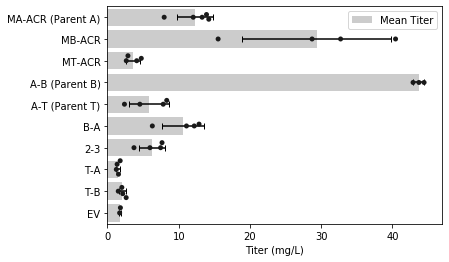

In [6]:
#Note, still using the old notation (ACR) for enzymes here becuase this cell accesses the original dataframe
key_ACRs=['MA-ACR','MB-ACR','MT-ACR','MAB-ACR','MAT-ACR','MTB-ACR','MBT-ACR','MTA-ACR','MBA-ACR','EV'] 
#Update names of ACRs to make naming simpler
parent_names={'MA-ACR':'MA-ACR (Parent A)','MB-ACR':'MB-ACR','MT-ACR':'MT-ACR','MAB-ACR':'A-B (Parent B)','MAT-ACR':'A-T (Parent T)','MBA-ACR':'B-A','MTA-ACR':'T-A','MBT-ACR':'2-3','MTB-ACR':'T-B','EV':'EV'}
re_named=[parent_names[k] for k in key_ACRs]

#Get the individual measurements of the titer and the corresponding labels from the main dataframe 

#Make a smaller dataframe to pull the AHR-ACR Fusion data from 
#Dates for AHR-ACR fusion experiments ['2020-02-03 00:00:00','2020-08-14 00:00:00','2020-02-24 00:00:00','2020-08-07 00:00:00']
df1=df[df['Date']=='2020-02-03 00:00:00']
df2=df[df['Date']=='2020-08-14 00:00:00']
df3=df[df['Date']=='2020-02-24 00:00:00']
df4=df[df['Date']=='2020-08-07 00:00:00']

df_small=pd.concat([df1,df2,df3,df4])

small_avg_titers,small_std_titers=avg_replicates(df_small)

avg_sorted_titers=pd.DataFrame()
avg_sorted_titers['Titer']=small_avg_titers.loc[key_ACRs]['Sum C6-C16']
avg_sorted_titers['Titer Error']=yerr=small_std_titers.loc[key_ACRs]['Sum C6-C16']

#Custom order for plotting
order=['MA-ACR','MB-ACR','MT-ACR','MAB-ACR','MAT-ACR','MBA-ACR','MBT-ACR','MTA-ACR','MTB-ACR','EV']
order_dict={order[i]:i for i in range(len(order))}

#Plot in order of increasing titer 
avg_sorted_titers['Order']=[order_dict[lab] for lab in avg_sorted_titers.index]

#Plot in different order 
avg_sorted_titers=avg_sorted_titers.sort_values('Order')

Fusions=pd.DataFrame()
Fusions['x']=[df_small.loc[i]['Sum C6-C16'] for i in df_small.index if df_small.loc[i]['Label'] in key_ACRs]
Fusions['label']=[df_small.loc[i]['Label'] for i in df_small.index if df_small.loc[i]['Label'] in key_ACRs]
Fusions['y']=[parent_names[k] for k in Fusions['label']]

#Get the corresponding mean so the df can be sorted easily
Fusions['Mean']=[avg_sorted_titers.loc[lbl]['Titer'] for lbl in Fusions['label']]
Fusions['Order']=[order_dict[lab] for lab in Fusions['label']]

#Sort the df
x=Fusions.sort_values('Order')['x']
y=Fusions.sort_values('Order')['y']

#Make the swarmplot
plt.figure()
plt.yticks(ticks=np.arange(len(key_ACRs)))
sns.swarmplot(x,y,color='0.1') 

#Add a bar plot to show the mean and error bars 
plt.barh(np.arange(len(key_ACRs)),avg_sorted_titers['Titer'],xerr=avg_sorted_titers['Titer Error'],color='0.8',label='Mean Titer',capsize=3)

plt.xlabel('Titer (mg/L)')
plt.ylabel('')
plt.legend()


The titers here are a subset of all replicates. Some of the samples shown here had many many more replicates (such as MA-ACR), so the titers deviate slightly from the final titers. 

# UCB Optimization (Figure 2)
Analyze the titers from the UCB optimization phase of the project (any data acquired during 2019).

,Titer,Error,Block,Round
ATR-83,60.501200,5.828747,13221112,11
ATR-80,60.119840,4.125665,23221112,11
ATR-86,56.040423,3.928841,13222112,12
ATR-82,54.337224,3.364470,23121112,11
ATR-69,54.101316,5.984295,23222112,10


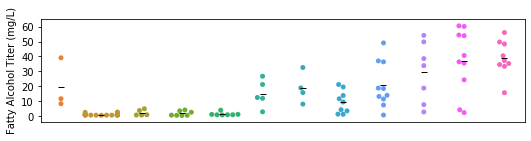

In [7]:
#Make a figure with only data points from 2019, showing a more representative view of the model training data
df19=df[df['Date']<='2019-05-03 00:00:00']

finalized19=pd.DataFrame(index=finalized_no_AHRs.index)
finalized19['Titer']=[df19[df19['Label']==L]['Sum C6-C16'].mean() for L in final_labels.loc[finalized19.index]['Label']]
finalized19['Error']=[df19[df19['Label']==L]['Sum C6-C16'].std() for L in final_labels.loc[finalized19.index]['Label']]
finalized19['Block']=finalized_no_AHRs['Block']
finalized19['Round']=finalized_no_AHRs['Round']

rounds=sorted(list(set(finalized19['Round'])))
round_avgs=[finalized19[finalized19['Round']==r]['Titer'].mean() for r in rounds]

plt.figure(figsize=(8.6696,1.8897))
sns.swarmplot(x=finalized19['Round'],y=finalized19['Titer'],palette=sns.color_palette('husl',13)[1:])
plt.plot(np.array(rounds)-1,round_avgs,'k_',zorder=10)

plt.yticks([0,10,20,30,40,50,60],[0,10,20,30,40,50,60])
plt.ylabel('Fatty Alcohol Titer (mg/L)')

plt.xticks([],[])
plt.xlabel('')
finalized19.loc[['ATR-80','ATR-83']]

#Show the top 5 sequences 
finalized19.sort_values(by='Titer',ascending=False).head()

Plot of ACR chimeras by round.

ATR-80 and ATR-83 are very similar in sequence and in titer. Do a quick analysis to determine whether they are statistically different from each other.

In [8]:
#Evaluate statistics manually
X83=df[df['Label']=='ACR-83']['Sum C6-C16'].mean() #ATR 83 mean
X80=df[df['Label']=='ACR-80']['Sum C6-C16'].mean() #ATR 80 mean

S83=df[df['Label']=='ACR-83']['Sum C6-C16'].std() #ATR 83 standard deviation
S80=df[df['Label']=='ACR-80']['Sum C6-C16'].std() #ATR 80 standard deviation

N83=df[df['Label']=='ACR-83']['Sum C6-C16'].count()
N80=df[df['Label']=='ACR-80']['Sum C6-C16'].count()

#Evaluate t using Welch's t-test
t=(X83-X80)/np.sqrt((S83**2/N83)+(S80**2/N80))
#Evaluate v

v80=N80-1
v83=N83-1
v=((S83**2/N83)+(S80**2/N80))**2/((S83**4/N83**2/v83)+(S80**4/N80**2/v80))

print('t = '+str(t),' v = ' +str(v))

#Using scipy (this is much faster)
from scipy.stats import ttest_ind

A=df[df['Label']=='ATR-83']['Sum C6-C16']
B=df[df['Label']=='ATR-80']['Sum C6-C16']
T=ttest_ind(A,B,equal_var=False)
print(T)

t = -1.447872043954887  v = 10.026550019845
Ttest_indResult(statistic=nan, pvalue=nan)


Because the p value is large (>0.1), these values are statistically the same

# Expression Level Analysis (Figure 3a)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 0, 'Expression Level (µg/mL/OD)')

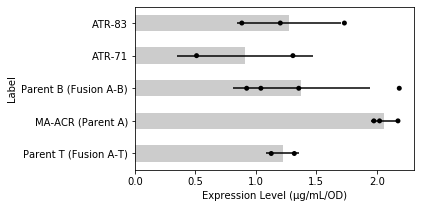

In [9]:
#Plot expression level for specific chimeras 
expression_df=df[df['Expression (ug/mL)']!='Not measured'][['Label','Expression (ug/mL)']]

exp_mean=[]
exp_err=[]
exp_ACRs=['MAT-ACR','MA-ACR','MAB-ACR','ACR-71','ACR-83']
for label in exp_ACRs:
    exp_mean.append(expression_df[expression_df['Label']==label]['Expression (ug/mL)'].mean())
    exp_err.append(expression_df[expression_df['Label']==label]['Expression (ug/mL)'].std())

#Plot expression level for specific chimeras 
expression_df=df[df['Expression (ug/mL)']!='Not measured'][['Label','Expression (ug/mL)','Date','Block_seq']]

#Add the updated expression labels to the dataframe
expression_df['Final_Label']=[str(final_labels[final_labels['Label']==L].index[0]) for L in expression_df['Label']]

plt.figure(figsize=(5,3))
#Divide by 20 (which was the OD )
#Swarmplot
swarm_plot_exp_df=expression_df[expression_df.Label.isin(exp_ACRs)]
swarm_plot_exp_df['Label']=pd.Categorical(swarm_plot_exp_df['Label'],exp_ACRs)

y=swarm_plot_exp_df['Label']
x=swarm_plot_exp_df['Expression (ug/mL)']/20
sns.swarmplot(x,y,color='k')

small_exp_df=pd.DataFrame(exp_mean,index=exp_ACRs,columns=['mean'])/20
small_exp_df['error']=np.array(exp_err)/20
small_exp_df['mean'].plot(kind='barh',xerr=small_exp_df['error'],color='0.8')

#Update the ticks
plt.yticks(np.arange(len(exp_ACRs)),[str(final_labels[final_labels['Label']==L].index[0]) for L in exp_ACRs])
plt.xlabel('Expression Level (µg/mL/OD)')


([<matplotlib.axis.XTick at 0x7ff388382bd0>,
 <a list of 5 Text xticklabel objects>)

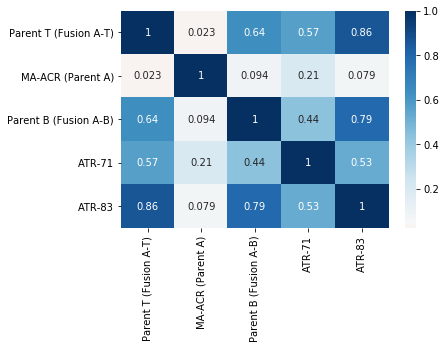

In [10]:
#Analyze the expression levels of the selected chimeras and determine if they are significantly different statistically:


exp_pvalues=pd.DataFrame(index=small_exp_df.index)

for c in small_exp_df.index:
    A=expression_df[expression_df['Label']==c]['Expression (ug/mL)']
    pvals=[]
    for c2 in small_exp_df.index:
        B=expression_df[expression_df['Label']==c2]['Expression (ug/mL)']
        T=ttest_ind(A,B,equal_var=False)
        pvals.append(T[1])
    exp_pvalues[c]=pvals
        
sns.heatmap(exp_pvalues,annot=True,cmap='RdBu',center=0.05)

#Update the ticks
plt.yticks(np.arange(len(exp_ACRs))+0.5,[str(final_labels[final_labels['Label']==L].index[0]) for L in exp_ACRs])

#Update the ticks
plt.xticks(np.arange(len(exp_ACRs))+0.5,[str(final_labels[final_labels['Label']==L].index[0]) for L in exp_ACRs],rotation=90)



The p values from the t-test are very high. The exception is the values for MA-ACR, which has a low p-values for Parent B, Parent T and ATR-83. This suggests that there is evidence that MA-ACR is statistically different from Parent T at a 95% confidence level, but not the others.

# Kinetics Analysis (Figure 3b)

In [11]:
#Load the data 
def load_data(filename,plate_layout,**kwargs):
    #read in the data
    df=pd.read_excel(filename,**kwargs,index_col=0).T
    df.drop('Temp. [°C]',axis=1,inplace=True)
    
    #load the plate layout file
    pl=pd.read_excel(plate_layout,index_col=0)
    pl=pl.dropna(how='all').dropna(axis=1,how='all') #drop out columns with no measurements 
    
    #Make the layout dictionary
    layout_dict={r+str(c):pl[c][r] for r in list(pl.index) for c in list(pl.columns)}
    
    #Add the sample type to the dataframe
    #df['Sample']=[layout_dict[k] for k in df.index]
    
    return df,pl,layout_dict

#Now make a function to calculate the rates

def calc_rates(df,n_pts):
    '''df should be a dataframe where the column names are ['Cylce Nr.','Time [s]',wells]
       outputs a dataframe with the slopes and intercepts of the best fit line for the first n_pts data points
    '''
    lines=pd.DataFrame(index=df.columns[1:])
    lines['Slopes']=[np.polyfit(df['Time [s]'][:n_pts],df[c][:n_pts],1)[0] for c in df.columns[1:]]
    lines['Intercepts']=[np.polyfit(df['Time [s]'][:n_pts],df[c][:n_pts],1)[1] for c in df.columns[1:]]
    
    return lines

#Now make a function to add the labels 

def label_lines(lines,layout_dict):
    lines['Sample']=[layout_dict[k] for k in lines.index]
    return lines

#Do all three steps
def get_rates(filename,plate_layout,n_pts=10,**kwargs):
    df,pl,ld=load_data(filename,plate_layout,**kwargs) #Load the data
    lines=calc_rates(df,n_pts) #Calculate the inital rates
    lines=label_lines(lines,ld) #Add labels to the initial rate dataframe
    
    #Also transpose the dataframe containing the data so the wells are the row headings and time becomes the column headings 
    df=df.set_index('Time [s]').T
    df=label_lines(df,ld) #Add the labels to the dataframe

    
    return lines,df


In [12]:
#Get data from 20200831
f1='Raw_Data/DNTB_absorbance_assay_Jonathan (Modified)_20200831_123632.xlsx'
pl1='Raw_Data/20200831_endpoint_plate_layout.xlsx'
rates1,traces1=get_rates(f1,pl1,n_pts=10,skiprows=37,usecols='A:BH',nrows=66)

#Get data from 20200904, plate 2 round 1 
f2='Raw_Data/DNTB_absorbance_assay_Jonathan (Modified)_20200904_123251_Plate_2.xlsx'
pl2='Raw_Data/20200904_plate_2_layout.xlsx'
rates2,traces2=get_rates(f2,pl2,n_pts=12,skiprows=37,usecols='A:BZ',nrows=46)

#Get data from 20200904, plate 2 round 2 
f3='Raw_Data/DNTB_absorbance_assay_Jonathan (Modified)_20200904_133840_Plate_2_part_2.xlsx'
rates3,traces3=get_rates(f3,pl2,n_pts=12,skiprows=37,usecols='A:BU',nrows=46)


Do a little processing to clean up the data


In [13]:
#Filter out CoA results from the 202020831 Data 
rates1=rates1[~rates1['Sample'].str.contains('CoA')]

#Get rid of outliers (noisy wells)
rates1.drop('H5',inplace=True) 
rates2.drop('B11',inplace=True) 


Average the replicates and put the data together

In [14]:
def average_replicates(df):
    '''Input: a dataframe with column named 'Sample' containing the sample ID corresponding to the well
       Replicates are averated based on the sample
       
       This function should work for the rates dataframe as well as a dataframe containing all individual measurements
       as long as the wells are the indices (row headings) and it contains a column with the sample ID
       '''

    avg=pd.DataFrame()
    err=pd.DataFrame()
    
    samples=sorted(list(df['Sample']))
    
    for s in samples:
        new_df=df.loc[df['Sample']==s].drop('Sample',axis=1)
        avg[s]=new_df.mean()
        err[s]=new_df.std()
        
    return avg,err


#Combine the rate data from each plate reader run
combined_lines=pd.concat([average_replicates(df)[0] for df in [rates1,rates2,rates3]],axis=1).T
combined_line_errs=pd.concat([average_replicates(df)[1] for df in [rates1,rates2,rates3]],axis=1).T


In [15]:
#Add columns to simplify analysis

def add_conc_and_ACR(df):
    '''input is a dataframe where the sample IDs are the row heading
       
       adds columns to the df to simplify sorting by concentration and ACR
    '''
    
    df['ACR']=[s.split(' + ')[0] for s in combined_lines.index]
    df['[CoA] (uM)']=[float(s.split(' uM')[0].split('+ ')[1]) for s in combined_lines.index]

    
    return df
  
combined_lines=add_conc_and_ACR(combined_lines)
combined_line_errs=add_conc_and_ACR(combined_line_errs)


In [16]:
#List the unique ACRs 
ACRs=sorted(list(set([s.split(' + ')[0] for s in combined_lines.index])))

#List the concentrations 
Concs=sorted(list(set([float(s.split(' uM')[0].split('+ ')[1]) for s in combined_lines.index])))

In [17]:
def sort_by_ACR(df):
    new_df=pd.DataFrame(columns=ACRs,index=Concs)
    
    for A in ACRs:
        for C in Concs:
            new_df[A][C]=df[df['ACR']==A].set_index('[CoA] (uM)')['Slopes'].loc[C]
        
    return new_df


Current Units: a.u./s

$A=b\epsilon C$ 

$C={A\over {b \epsilon}}$

In [18]:
b=0.38 #Path length in cm
epsilon=14150 #Molar extinction coefficient of TNB in (M^-1)(cm^-1)

acp_rates=sort_by_ACR(combined_lines)/b/epsilon*(10**6) #uM/S  
acp_rate_errors=sort_by_ACR(combined_line_errs)/b/epsilon*(10**6)
    

Text(0, 0.5, 'Rate (µM TNB /s)')

<Figure size 288x180 with 0 Axes>

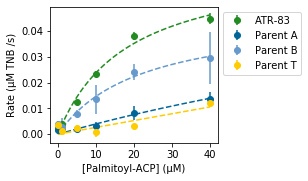

In [19]:
from scipy.optimize import curve_fit

#Specify the michaelis menten kinetics equation
def func(S,Km,Vmax):
    return Vmax*S/(Km+S)

color_dict={'MA-ACR':'#006699','MAB-ACR':'#6699CC','MAT-ACR':'#FFCC00','ACR-83':'forestgreen'} #dictionary for making the colors match up
renamed_ACRs={'MA-ACR':'Parent A','MAB-ACR':'Parent B','MAT-ACR':'Parent T','ACR-83':'ATR-83'} #Dictionary for renaming ACRs (consistency )

#Apply the non-linear regression to all the cuves 
x=acp_rates.index #set the x axis
plt.figure(figsize=(4,2.5))

params=pd.DataFrame(index=['Km (µM)','Vmax (µM/s)','Km Error (µM)','Vmax Error (µM/s)'])

plt.figure(figsize=(3,2.5))
for A in acp_rates.columns.drop('No ACR'):
    y=acp_rates[A] #get the y values 
    popt,pcov=curve_fit(func,x,y,p0=[1,np.max(y)],bounds=[(0,0),(100000,10)]) #Fit the curve 
    
    #Update the parameters dataframe
    params[A]=list(popt)+list(np.sqrt(np.diag(pcov)))
    
    plt.errorbar(x,acp_rates[A],yerr=acp_rate_errors[A],fmt='o',color=color_dict[A],label=renamed_ACRs[A])
    
    xsmooth=np.linspace(0,np.max(x))
    plt.plot(xsmooth,func(xsmooth,*popt),'--',color=color_dict[A])
    
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('[Palmitoyl-ACP] (µM)')
plt.ylabel('Rate (µM TNB /s)')

Plot of the initial rate data for palmitoyl-ACP activity and the Michaelis-Menten model fits.

In [20]:
params=params.T

enzyme_conc=1 #concentration of enzyme in micromolar

params['kcat (s^-1)']=params['Vmax (µM/s)']/enzyme_conc
params['kcat/Km (µM^-1 s^-1)']=params['kcat (s^-1)']/params['Km (µM)']
params['kcat/Km (µM^-1 min^-1)']=params['kcat/Km (µM^-1 s^-1)']*60
params

,Km (µM),Vmax (µM/s),Km Error (µM),Vmax Error (µM/s),kcat (s^-1),kcat/Km (µM^-1 s^-1),kcat/Km (µM^-1 min^-1)
ACR-83,18.306513,0.067438,4.521317e+00,0.007616,0.067438,0.003684,0.221031
MA-ACR,197.581726,0.082805,3.380448e+02,0.121588,0.082805,0.000419,0.025146
MAB-ACR,21.951835,0.046852,8.711121e+00,0.009073,0.046852,0.002134,0.128059
MAT-ACR,25096.489283,6.647292,1.292897e+07,3419.804142,6.647292,0.000265,0.015892


# Training the Final Regression Model (Supplementary Figure 5)


In [21]:
#Load the structural representation

structural_encoding=pickle.load(open('ACR_structural_encoding.p','rb'))

#Don't use Y, Yall, or act from the pickled structure representation, only use X, Xall, chimeras, all_chimeras and chimera2AA
#Instead of Y, use the titers from this workbook to calculate Y 
Y_orig=structural_encoding[1]
X=structural_encoding[0]
chimeras=structural_encoding[3]
Xall=structural_encoding[4]
all_chimeras=structural_encoding[5]
chimera2AA=structural_encoding[6]

#Make a dict mapping chimera (block seq) to Y
#I'm doing this as an extra step just in case something happens to get misaligned in the dataframe
chimera2Y={str(finalized_no_AHRs['Block'].iloc[i]):np.log(finalized_no_AHRs['Titer'].iloc[i]) for i in range(len(finalized_no_AHRs))}

#Get Y
Y=np.array([chimera2Y[c] for c in chimeras])
Y=Y.reshape(len(Y),1) #Reshape Y to make it work properly 


There are a few cases where the updated data deviates slightly from the "original" data due to additional repicates being performed. However, this graph shows that in most cases the original dataset and the update dataset fall along the x=y line 

In [22]:
#Cross validate with the updated Y (This step can take a while)
lam_array,cc_array,err_2_array=UCB_tools.GP_cross_val_scan(X,Y,lam_start=-6,lam_end=4,num_lam=100,showplot='False')


/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:162: RuntimeWarning: divide by zero encountered in true_divide
  Xtr = (Xtr - Xmean)/Xstd
/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:162: RuntimeWarning: invalid value encountered in true_divide
  Xtr = (Xtr - Xmean)/Xstd
/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:163: RuntimeWarning: invalid value encountered in true_divide
  Xtst = (Xtst - Xmean)/Xstd


Check the cross validation scans. 

Text(0, 0.5, 'Squared Error')

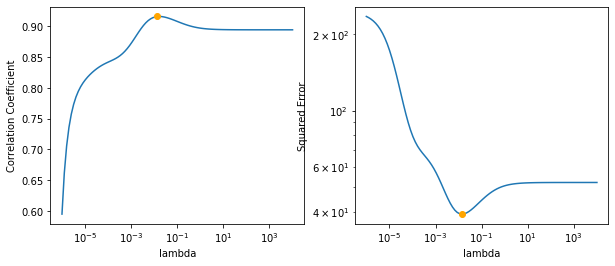

In [23]:
lam_all=lam_array[np.argmin(err_2_array)]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.semilogx(lam_array,cc_array,'-')
plt.semilogx(lam_all,cc_array[np.argmax(cc_array)],'o', color='orange')
plt.xlabel('lambda')
plt.ylabel('Correlation Coefficient')

plt.subplot(1,2,2)
plt.loglog(lam_array,err_2_array,'-')
plt.loglog(lam_all,err_2_array[np.argmin(err_2_array)],'o',color='orange')
plt.xlabel('lambda')
plt.ylabel('Squared Error')


Plot the final cross validated result (Figure S5)

/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:162: RuntimeWarning: divide by zero encountered in true_divide
  Xtr = (Xtr - Xmean)/Xstd
/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:162: RuntimeWarning: invalid value encountered in true_divide
  Xtr = (Xtr - Xmean)/Xstd
/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:163: RuntimeWarning: invalid value encountered in true_divide
  Xtst = (Xtst - Xmean)/Xstd


Text(3, 0, 'CC=0.9159')

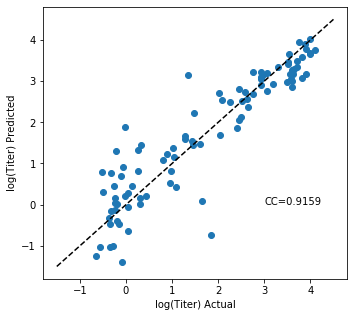

In [24]:
#Plot the cross validation curves
Y_hat_cv=UCB_tools.GP_cross_val(X,Y,lam_all)  #Cross validate the model with the given value of lambda
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(Y,Y_hat_cv,'o')
plt.plot([-1.5, 4.5],[-1.5, 4.5],'k--')
plt.xlabel('log(Titer) Actual')
plt.ylabel('log(Titer) Predicted')
plt.text(3,0,'CC=' + str(round(np.corrcoef(Y[:,0],Y_hat_cv[:,0])[0,1],4)))


The model shows a very clear correlation between the predicted and actual titers after leave-one-out cross validation.

# Analysis of Regression Models (Figure 4a) 
Use the regression model to back-calculate contributions that each sequence block makes to the activity of any chimera containing it. 

In [25]:
#First rebuild the encoding so that predictions can be made over tested and untested seqs simultaneously
X_all_seqs=np.vstack((X,Xall))

#Make a list of all the block sequences excluding the tested 
all_untested_block_seqs=[[c for c in chimera2AA if chimera2AA[c]==all_chimeras[i]][0] for i in range(len(Xall))]

#Combine the lists of block seqs 
blocks_combined_all=chimeras+all_untested_block_seqs


In [26]:
#Make predictions over the sequence spaces 
Y_combined_all, CI_combined_all=UCB_tools.GPfit(X,Y,X_all_seqs,lam_all)


/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:162: RuntimeWarning: divide by zero encountered in true_divide
  Xtr = (Xtr - Xmean)/Xstd
/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:162: RuntimeWarning: invalid value encountered in true_divide
  Xtr = (Xtr - Xmean)/Xstd
/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:163: RuntimeWarning: divide by zero encountered in true_divide
  Xtst = (Xtst - Xmean)/Xstd
/Users/jgreenhalgh2/Desktop/ML_Guided_AAR_Eng_Analysis_and_Protabank_File_Prep/Analysis/UCB_tools.py:163: RuntimeWarning: invalid value encountered in true_divide
  Xtst = (Xtst - Xmean)/Xstd


Calculate the contributions for each block (Figure 4a).

In [27]:
#Define a function to count the occurences of each block 

def get_average_activity(Y_combined,blocks_combined):
    #Y_combined is the list of predicted activities
    #blocks_combined is the list of sequences corresponding to the predicted activities 
    
    Y_summed=np.zeros([3,8])  #Running Sum of Y for sequences containing the block in question at position i,j
    Instances=np.zeros([3,8]) #Keep a running total of the number of sequences containing the blocks in question

    for i in range(len(blocks_combined)):
        seq=blocks_combined[i]
        for j in range(len(seq)):
            block=seq[j]
            parent=int(block)-1

            if (parent,j)!=(1,5): #If the block is not parent 2 at position 6
                Y_summed[parent][j]+=Y_combined[i]
                Instances[parent][j]+=1
            if (parent,j)==(1,5): #If the block is parent 2 at position 6 (only 1 case, the WT)
                Y_summed[parent-1][j]+=Y_combined[i]
                Instances[parent-1][j]+=1
                
                
    Y_summed_df=pd.DataFrame(Y_summed,columns=['b1','b2','b3','b4','b5','b6','b7','b8'],index=['p1','p2','p3'])
    Instances_df=pd.DataFrame(Instances,columns=['b1','b2','b3','b4','b5','b6','b7','b8'],index=['p1','p2','p3'])

                
    return(Y_summed_df,Instances_df)


Coefficients with all sequences


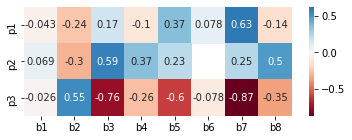

In [28]:
Y_summed_all,Instances_all=get_average_activity(Y_combined_all,blocks_combined_all)

Averaged_df=Y_summed_all/Instances_all

#Subtract out the average predicted titer 
Centered_df=Averaged_df-np.average(Y_combined_all)

#Fix the coefficient for p2 block 6 so that it matches p1 block 6 (the sequences are the same)
#Centered_df['b6']['p2']=Centered_df['b6']['p1'] #Fil this in later

plt.figure(figsize=(6,2))
sns.heatmap(Centered_df,center=0,cmap='RdBu',annot=True)
print('Coefficients with all sequences')

For these coefficients, p1 is MA-ACR, p2 is Parent B, and p3 is Parent T. The more positive the number, the higher chance a sequence containing that block would have a higher titer. The more negative, the less likely it would produce a lot of alcohols. 


# Charge near the active site (Figure 4c)


In [29]:
from scipy.spatial import distance 
from scipy.stats import f_oneway 
from scipy.stats import ttest_ind
from pymol import cmd
from pymol import stored

In [30]:
#Read in the pdb file for the MA-ACR model and pull out the lines for each of the atoms 
model='maacr_prepacked_local_dock_0685.pdb'
file_list=[l for l in open(model,'r') if l[:4]=='ATOM']

cmd.load(model) #load the file
cmd.orient()    #oreint the file

 PyMOL not running, entering library mode (experimental)


In [31]:
#Load the block alignment
block_aln=pickle.load(open('acr_block_aln.p','rb'))
block_aln_df=pd.DataFrame(block_aln)


In [32]:
#Make file_list into a coordinate df (coord_df)
coord_df=pd.DataFrame()
coord_df['Resn']=[l[17:20] for l in file_list]
coord_df['ba_Resi']=[int(l[23:26])+3 if int(l[23:26])>67 and l[21]=='A' else int(l[23:26]) for l in file_list] #To match the block alignment...
coord_df['Resi']=[int(l[23:26]) for l in file_list] #Original numbering
coord_df['x']=[float(l[30:38]) for l in file_list]
coord_df['y']=[float(l[38:46]) for l in file_list]
coord_df['z']=[float(l[46:54]) for l in file_list]
coord_df['chain']=[l[21] for l in file_list]
coord_df['atom']=[l[77:80] for l in file_list]


In [33]:
#Compressed form 
def get_resis_within_radius(radius):
    '''Function to determine a list of all positions containing a charged residue based on the above coordinates'''
    cmd.select('chain A within '+str(radius)+' of chain B')
    #Make a list of the the atom numbers within the threshold 
    stored.atom_list=[]
    cmd.iterate('sele','stored.atom_list.append(resi)')
    resi_num_list=list(sorted(set(stored.atom_list)))
    #Make a coord_df of just the resi info for chain A (ACR)
    resi_nums=coord_df[coord_df['chain']=='A'][['Resn','ba_Resi','Resi']]

    #Drop out the replicate rows 
    resi_nums.drop_duplicates(inplace=True)
    resi_nums.index=[str(l) for l in resi_nums['Resi']]
    
    #Now extract all the ba_resi values and read into block_aln_coord_df
    in_radius=block_aln_df.loc[list(resi_nums.loc[resi_num_list]['ba_Resi']-1)]

    charged_resis=['R','K','E','D']

    #Look at just those residues in the radius that are charged 
    charged_in_radius=in_radius[(in_radius[1].isin(charged_resis)) | (in_radius[2].isin(charged_resis)) | (in_radius[3].isin(charged_resis))]

    return charged_in_radius

In [34]:
def count_charged_resis(chim,charged_in_radius):
    '''Function to count specifically the number of positive and negative residues given a list of charged residues and a chimera sequence'''
    neg_r=['D','E']
    pos_r=['K','R']
    pos=0
    neg=0
    for i in range(len(chim)):
        charged_in_radius[charged_in_radius[0]==i][int(chim[i])]
        #Count each kind of residue
        for r in neg_r:
            neg+=charged_in_radius[charged_in_radius[0]==i][int(chim[i])].str.count(r).sum()
        for r in pos_r:
            pos+=charged_in_radius[charged_in_radius[0]==i][int(chim[i])].str.count(r).sum()

    net=pos-neg
    tot=pos+neg
    return [pos,neg,net,tot]

In [35]:
#Build dfs containing the information about charges at different thresholds
in_radius10=get_resis_within_radius(10)
charged10=[count_charged_resis(str(chim),in_radius10) for chim in finalized_no_AHRs['Block']]
charged10=pd.DataFrame(charged10,columns=['pos','neg','net','tot'],index=finalized_no_AHRs.index)
charged10['Titer']=finalized_no_AHRs['Titer'] #Add titer to the df
charged10['Block']=finalized_no_AHRs['Block'] #Add block sequence to the df


Text(0.5, 0, 'Net Charge Within 10Å of ACP')

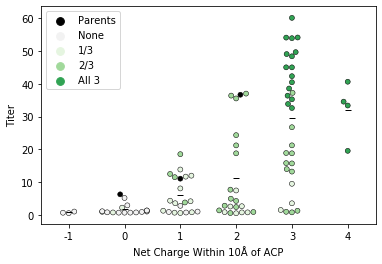

In [36]:
parents=['MA-ACR (Parent A)','Parent B (Fusion A-B)','Parent T (Fusion A-T)']

col='net'
dframe=charged10
plt.figure()
dframe['parent']=['Parents' if c in parents else '' for c in dframe.index]
dframe['xxxBxxAB']=['Contains Blocks' if str(dframe['Block'][c])[3]=='2' and str(dframe['Block'][c])[7]=='2' and str(dframe['Block'][c])[6]=='1' else 'Parents' if c in parents else 'Doesn\'t Contain All' for c in dframe.index]
dframe['b4pB']=['Parents' if c in parents else 'Contains Blocks' if str(dframe['Block'][c])[3]=='2' else '' for c in dframe.index]
dframe['b6pA']=['Parents' if c in parents else 'Contains Blocks' if str(dframe['Block'][c])[3]=='2' else '' for c in dframe.index]
dframe['b7pA']=['Parents' if c in parents else 'Contains Blocks' if str(dframe['Block'][c])[6]=='1' else '' for c in dframe.index]
dframe['b8pB']=['Parents' if c in parents else 'Contains Blocks' if str(dframe['Block'][c])[7]=='2' else '' for c in dframe.index]
dframe['Combined']=dframe['b4pB']+dframe['b7pA']+dframe['b8pB']

#Make sure these all match up
hue_order=['Parents','None','1/3','2/3','All 3']
dframe['Combined_nums']=[hue_order[0] if c in parents else hue_order[-1] if dframe['Combined'][c]==3*'Contains Blocks' else hue_order[-2] if dframe['Combined'][c]==2*'Contains Blocks' else hue_order[-3] if dframe['Combined'][c]=='Contains Blocks' else hue_order[-4] for c in dframe.index]
color_pal={hue_order[0]:(0,0,0),hue_order[1]:(0.95,0.95,0.95),hue_order[2]:'#e5f5e0',hue_order[3]:'#a1d99b',hue_order[4]:'#31a354'}

#Contains b4pB, b7pA and b8pB
sns.swarmplot(x=dframe[col],y=dframe['Titer'],marker='o',hue=dframe['Combined_nums'],palette=color_pal,hue_order=hue_order,edgecolor='k',linewidth=0.5)
plt.legend(title='')

means=[dframe[dframe[col]==i]['Titer'].mean() for i in sorted(set(dframe[col]))]
plt.plot([i-dframe[col].min() for i in sorted(set(dframe[col]))],means,'k_',zorder=10)

plt.xlabel('Net Charge Within 10Å of ACP')


Plot of chimera titer grouped by net charge near the ACP binding site (based on a model of MA-ACR). There appears to be a positive correlation between sequences with a high net charge and a high activity.

# RASPP Analysis (Supplementary Figure 1)

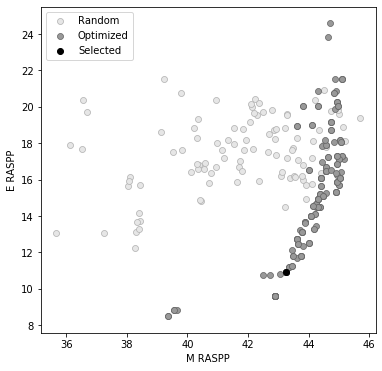

In [37]:
#Load the data 
rasppdf=pd.read_excel('Raw_Data/RASPP_Output_9-27-17_condensed.xlsx')

#Plot the data 
plt.figure(figsize=(6,6))
sns.scatterplot(rasppdf['M Rand'], rasppdf['E Rand'],marker='o',label='Random',color='0.9',edgecolor='0.7')
sns.scatterplot(rasppdf['M RASPP'],rasppdf['E RASPP'],marker='o',label='Optimized',color='0.6',edgecolor='0.4')

#These two data points are the same (E and m) even thorugh they're from slightly different libs
plt.scatter(rasppdf['M RASPP'][59],rasppdf['E RASPP'][59],marker='o',label='Selected',color='k',edgecolor='k') 
plt.legend()

RASPP optimization curve, each point represents one potential library (set of breakpoints). The library selected is shown in black. 

# UCB Round 1 Data (Supplementary Figure 2)

In [38]:
#Load the BL21 (DE3) and CM24 Datasets
bl21=pd.read_excel('../Relabeling_and_Protabank_Prep/Relabeled_Data/BL21_Relabeled.xlsx')
cm24=pd.read_excel('../Relabeling_and_Protabank_Prep/Relabeled_Data/CM24_Relabeled.xlsx',index_col=0)

Text(0, 0.5, 'Titer (mg/L)')

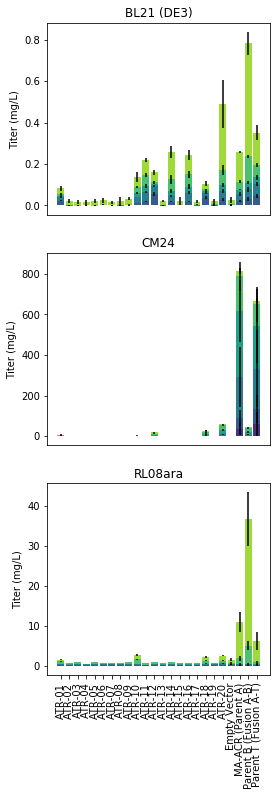

In [39]:
test_set=sorted(list(set(bl21['Final_Label'])))
test_set.remove('Empty Backbone')
lengths=['C6','C8','C10','C12','C14','C16'] #carbon chain lengths
cmap=sns.color_palette('viridis',6)
cdict={lengths[i]:cmap[i] for i in range(len(lengths))}

plt.figure(figsize=(4,12))
bottoms=np.zeros(len(test_set))

plt.subplot(3,1,1)
plt.title('BL21 (DE3)') #BL21(DE3) Data
for c in lengths[1:]: #note fewer chain lengths for BL21 (DE3) dataset
    c_avg=[bl21[bl21['Final_Label']==L][c].mean() for L in test_set] #Average the replicates
    c_err=[bl21[bl21['Final_Label']==L][c].std() for L in test_set]  #Find the standard deviation
    plt.bar(np.arange(len(test_set)),c_avg,bottom=bottoms,yerr=c_err,color=cdict[c])#Plot the data
    bottoms=bottoms+c_avg                                            #Update the bottom
plt.xticks([])
plt.ylabel('Titer (mg/L)')

plt.subplot(3,1,2)
plt.title('CM24') #CM24 Data
bottoms=np.zeros(len(test_set))
for c in lengths: 
    c_avg=[cm24[cm24['Final_Label']==L][c].mean() for L in test_set] #Average the replicates
    c_err=[cm24[cm24['Final_Label']==L][c].std() for L in test_set]  #Find the standard deviation
    plt.bar(np.arange(len(test_set)),c_avg,bottom=bottoms,yerr=c_err,color=cdict[c])#Plot the data
    bottoms=bottoms+c_avg    #Update the bottom
plt.xticks([])
plt.ylabel('Titer (mg/L)')
    
plt.subplot(3,1,3)    
plt.title('RL08ara') #RL08ara Data
bottoms=np.zeros(len(test_set))
for c in lengths: 
    c_avg=[df[df['Final_Label']==L][c].mean() for L in test_set] #Average the replicates
    c_err=[df[df['Final_Label']==L][c].std() for L in test_set]  #Find the standard deviation
    plt.bar(np.arange(len(test_set)),c_avg,bottom=bottoms,yerr=c_err,color=cdict[c])#Plot the data
    bottoms=bottoms+c_avg
plt.xticks(np.arange(len(test_set)),test_set,rotation=90)
plt.ylabel('Titer (mg/L)')

Plot of the activity of the initial 20 sequences designed in the test set. The sequences were tested in three different strains.

# Gel Calibration Curve (Supplementary Figure 3)

Text(0, 0.5, 'Normalized Intensity')

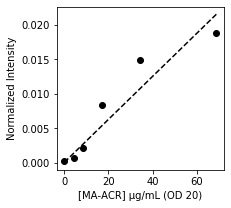

In [40]:
gel_df=pd.read_excel('Raw_Data/2020_MA-ACR_Expression_Standard_Curves.xlsx')
gel_df.set_index(gel_df['[MA-ACR] ug/mL (OD 20)'],inplace=True)
gel_df.drop('[MA-ACR] ug/mL (OD 20)',axis=1,inplace=True)

plt.figure(figsize=(3,3))
x=gel_df.index
y=gel_df['20200820_Gel_1']
plt.plot(x,y,'ko')
#Slope,int values from excel workbook
slope,intercept=0.000311765,3.30771E-05
plt.plot(x,slope*x+intercept,'k--')
plt.xlabel('[MA-ACR] µg/mL (OD 20)')
plt.ylabel('Normalized Intensity')

Standard curve relating the band intensity of MA-ACR to the concentration of the sample. 

# Comparison of in vitro CoA and ACP Activities (Supplementary Figure 4)

In [41]:
#Get data from part 1 
f4='Raw_Data/DNTB_absorbance_assay_Jonathan (Modified)_20200908_122446_Part_1.xlsx'
plate_layout='Raw_Data/20200908_Plate_Layout.xlsx'
rates4,traces4=get_rates(f4,plate_layout,n_pts=5,skiprows=37,usecols='A:AV',nrows=50)

#Get data part 2
f5='Raw_Data/DNTB_absorbance_assay_Jonathan (Modified)_20200908_125709_Part_2.xlsx'
rates5,traces5=get_rates(f5,plate_layout,n_pts=5,skiprows=37,usecols='A:AV',nrows=50)


In [42]:
#Get rid of outliers (noisy wells)
rates4.drop('B12',inplace=True) 
traces4.drop('B12',inplace=True)


In [43]:
def add_conc_and_ACR(df):
    '''input is a dataframe where the sample IDs are the row heading
       
       adds columns to the df to simplify sorting by concentration and ACR
    '''
    
    df['ACR']=[s.split(' + ')[0] for s in df.index]
    df['[CoA] (uM)']=[float(s.split(' uM')[0].split('+ ')[1]) for s in df.index]
    
    return df

def sort_by_ACR(df):
    new_df=pd.DataFrame(columns=ACRs,index=Concs)
    
    for A in ACRs:
        for C in Concs:
            new_df[A][C]=df[df['ACR']==A].set_index('[CoA] (uM)')['Slopes'].loc[C]
        
    return new_df
        


In [44]:

combined_lines=pd.DataFrame()
combined_line_errs=pd.DataFrame()
#Combine the rate data from each plate reader run
combined_lines=pd.concat([average_replicates(df)[0] for df in [rates4,rates5]],axis=1).T
combined_line_errs=pd.concat([average_replicates(df)[1] for df in [rates4,rates5]],axis=1).T



In [45]:
#Add columns to simplify analysis

combined_lines=add_conc_and_ACR(combined_lines)
combined_line_errs=add_conc_and_ACR(combined_line_errs)


In [46]:
#List the unique ACRs 
ACRs=sorted(list(set([s.split(' + ')[0] for s in combined_lines.index])))

#List the concentrations 
Concs=sorted(list(set([float(s.split(' uM')[0].split('+ ')[1]) for s in combined_lines.index])))

rates=sort_by_ACR(combined_lines)    
rate_errors=sort_by_ACR(combined_line_errs)

In [47]:
#Get the averages of the traces
traces4_avg,traces4_err=average_replicates(traces4)
traces5_avg,traces5_err=average_replicates(traces5)

In [48]:
#Set up for re-calculating and re-plotting the initial rates 

#Make fucntions to streamline rate calculation
def calc_rate(time,trace,npts):
    slope,intercept=np.polyfit(time[:npts],trace[:npts],1)
    return slope,intercept

def init_slope(x,slope,intercept):
    y=intercept+slope*x
    return y

#Get a list of the palmitoyl-CoA Concentrations 
CoA_Concs=sorted(list(set([l.split(' + ')[1] for l in combined_lines.index])))

#Reorder the list 
CoA_Concs[2],CoA_Concs[3],CoA_Concs[4],CoA_Concs[5]=CoA_Concs[5],CoA_Concs[2],CoA_Concs[3],CoA_Concs[4]

#Get a colormap 
Colors=sns.color_palette('viridis',len(CoA_Concs))

#Color Dictionary 
CD={CoA_Concs[i]:Colors[i] for i in range(len(CoA_Concs))}

#Make a dictionary to map the number of points used for fitting the initial rate to the concentration of CoA
npts_dict={0:20,1:20,5:20,10:5,20:4,40:20}

In [49]:
new_rates=[]

#Loop through first batch
for t in traces4.T:
    rate=calc_rate(list(traces4.columns[:-1]),list(traces4.T[t][:-1]),npts_dict[float(traces4.T[t].loc['Sample'].split(' ')[2])])[0]
    new_rates.append([traces4.T[t].loc['Sample'],rate])

#Loop through second batch
for t in traces5.T:
    rate=calc_rate(list(traces5.columns[:-1]),list(traces5.T[t][:-1]),npts_dict[float(traces5.T[t].loc['Sample'].split(' ')[2])])[0]
    new_rates.append([traces5.T[t].loc['Sample'],rate])
    

In [50]:
new_rates=pd.DataFrame(new_rates,columns=['Sample','Slopes']) #Pack the newly calculated rates into a dataframe 

#Average the replicates 
avg_rates,err_rates=average_replicates(new_rates)[0].T,average_replicates(new_rates)[1].T

#Add labels for the ACR and the concentration of CoA
avg_rates=add_conc_and_ACR(avg_rates)
err_rates=add_conc_and_ACR(err_rates)

#Sort by ACR 
avg_rates_sorted=sort_by_ACR(avg_rates)
err_rates_sorted=sort_by_ACR(err_rates)


Text(0, 0.5, 'Rate Palmitoyl-ACP Consumption (µM TNB/s)')

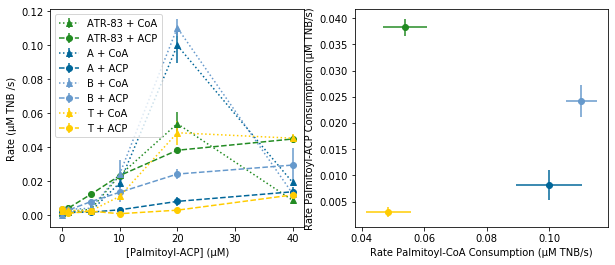

In [51]:
avg_rates_sorted=avg_rates_sorted/b/epsilon*(10**6) #uM/S
err_rates_sorted=err_rates_sorted/b/epsilon*(10**6)
coa_rates_sorted=avg_rates_sorted
coa_error_sorted=err_rates_sorted

color_dict={'MA-ACR':'#006699','MAB-ACR':'#6699CC','MAT-ACR':'#FFCC00','ACR-83':'forestgreen'} #dictionary for making the colors match up
renamed_ATRs={'MA-ACR':'A','MAB-ACR':'B','MAT-ACR':'T','ACR-83':'ATR-83'} #Dictionary for renaming ACRs (consistency )

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for A in coa_rates_sorted.columns:
    plt.errorbar(coa_rates_sorted.index,coa_rates_sorted[A],yerr=coa_error_sorted[A],fmt=':^',color=color_dict[A],label=renamed_ATRs[A]+' + CoA')
    plt.errorbar(acp_rates.index,acp_rates[A],yerr=acp_rate_errors[A],fmt='--o',color=color_dict[A],label=renamed_ATRs[A]+' + ACP')
    
plt.xlabel('[Palmitoyl-ACP] (µM)')
plt.ylabel('Rate (µM TNB /s)')    
plt.legend(loc='upper left')

plt.subplot(1,2,2)
#Plot the activities at 20 uM for CoA vs. ACP
for c in coa_rates_sorted.columns:
    plt.errorbar(coa_rates_sorted.loc[20][c],acp_rates.loc[20][c],xerr=coa_error_sorted.loc[20][c],yerr=acp_rate_errors.loc[20][c],fmt='o',color=color_dict[c])
    
plt.xlabel('Rate Palmitoyl-CoA Consumption (µM TNB/s)')
plt.ylabel('Rate Palmitoyl-ACP Consumption (µM TNB/s)')

Comparison of the activities of select sequences on palmitoyl-ACP and palmitoyl-CoA

# Create Source Data File 

In [52]:
#Make a dataframe containing the raw data used to plot figure 4
fig4=pd.DataFrame(df[['Label','Sum C6-C16','Block_seq','Date']],index=df.index)

#Add the updated labels to the dataframe 
fig4['Final_Label']=[final_labels[final_labels['Label']==L].index.values[0] for L in fig4['Label']]

#Drop out EV and AHR-ATR fusions (they weren't used in the plot for figure 4)
for L in ['Empty Vector','Empty Backbone','MB-ACR','MT-ACR','Fusion T-A','Fusion T-B','Fusion B-A','Fusion B-T']:
    fig4=fig4[fig4['Final_Label']!=L]

#Add the net charge to the fig4 dataframe using the dframe object as a dictionary 
fig4['Net Charge']=[dframe.loc[L]['net'] for L in fig4['Final_Label']]

In [53]:
#Re-organized the dataframes containing the raw data to be in a consistent order
df_reordered=df[['Final_Label','Block_seq','C6','C8','C10','C12','C14','C16','Sum C6-C16','OD (10 fold diluted)','Expression (ug/mL)','Date']]
df19_reordered=df19[['Final_Label','Block_seq','C6','C8','C10','C12','C14','C16','Sum C6-C16','OD (10 fold diluted)','Expression (ug/mL)','Date']]
df_small_reordered=df_small[['Final_Label','Block_seq','C6','C8','C10','C12','C14','C16','Sum C6-C16','OD (10 fold diluted)','Expression (ug/mL)','Date']]
exp_df_reordered=expression_df[['Final_Label','Block_seq','Expression (ug/mL)']]
fig4_reordered=fig4[['Final_Label','Block_seq','Sum C6-C16','Net Charge','Date']]
cm24_reordered=cm24[['Final_Label','Block_seq','C6','C8','C10','C12','C14','C16','Date']]
bl21_reordered=bl21[['Final_Label','Block_seq','C8','C10','C12','C14','C16','Date']]

cm24_reordered.index.rename('CM24',inplace=True)
bl21_reordered.index.rename('BL21 (DE3)',inplace=True)


In [54]:
#Rename the indices on the raw time traces for the CoA and ACP experiments
traces1.index.rename('Well \ Time (s)',inplace=True)
traces2.index.rename('Well \ Time (s)',inplace=True)
traces3.index.rename('Well \ Time (s)',inplace=True)
traces4.index.rename('Well \ Time (s)',inplace=True)
traces5.index.rename('Well \ Time (s)',inplace=True)


In [55]:
#Make a dataframe containing the data for figure S5
cross_val_df=pd.DataFrame([Y[:,0],Y_hat_cv[:,0]]).T
cross_val_df.columns=['Y actual','Y Predicted']

In [56]:
#Show the averaged data for Supplementary Figure 5
table5=pd.DataFrame(index=finalized.index)

table5['Block_seq']=[df[df['Final_Label']==L]['Block_seq'].iloc[0] for L in table5.index]
table5['UCB Titer (mg/L)']=[df19[df19['Final_Label']==L]['Sum C6-C16'].mean() for L in table5.index]
table5['UCB Titer Standard Deviation']=[df19[df19['Final_Label']==L]['Sum C6-C16'].std() for L in table5.index]
table5['n (UCB)']=[len(df19[df19['Final_Label']==L]['Sum C6-C16']) for L in table5.index]
table5['Final Titer (mg/L)']=[df[df['Final_Label']==L]['Sum C6-C16'].mean() for L in table5.index]
table5['Final Titer Standard Deviation']=[df[df['Final_Label']==L]['Sum C6-C16'].std() for L in table5.index]
table5['n (Final)']=[len(df[df['Final_Label']==L]['Sum C6-C16']) for L in table5.index]

In [57]:
#Export data to the source data spreadsheet
with pd.ExcelWriter('Source Data.xlsx') as writer:  
    
    #Main Figures
    df_small_reordered.to_excel(writer,sheet_name='Figure 1') #Figure 1
    df19_reordered.to_excel(writer,sheet_name='Figure 2')     #Figure 2
    exp_df_reordered.to_excel(writer,sheet_name='Figure 3a')  #Figure 3a                                                           
    traces1.to_excel(writer,sheet_name='Figure 3b')           #Figure 3b
    traces2.to_excel(writer,sheet_name='Figure 3b',startrow=len(traces1)+3)
    traces3.to_excel(writer,sheet_name='Figure 3b',startrow=len(traces1)+len(traces2)+6)    
    fig4_reordered.to_excel(writer,sheet_name='Figure 4c')    #Figure 4c
    df_reordered.to_excel(writer,sheet_name='RL08ara Data')   #Compiled RL08ara data (used in multiple figures)
    
    #Supplementary Figures 
    rasppdf.to_excel(writer,sheet_name='Supplementary Figure 1')       #Figure S1
    bl21_reordered.to_excel(writer,sheet_name='Supplementary Figure 2') #Figure S2 (BL21 DE3,CM24)
    cm24_reordered.to_excel(writer,sheet_name='Supplementary Figure 2',startrow=len(bl21_reordered)+3) #Figure S2 (BL21 DE3,CM24)
    gel_df.to_excel(writer,sheet_name='Supplementary Figure 3')        #Figure S3 (Gel)
    traces4.to_excel(writer,sheet_name='Supplementary Figure 4')       #Figure S4
    traces5.to_excel(writer,sheet_name='Supplementary Figure 4',startrow=len(traces4)+3)
    cross_val_df.to_excel(writer,sheet_name='Supplementary Figure 5')#Figure S5
    
    #Table S5
    table5.to_excel(writer,sheet_name='Supplementary Table 5')
    